In [251]:
import numpy as np; import pandas as pd
import scipy as sp; import scipy.stats as st
import torch; import torch.nn as nn
#use numba's just-in-time compiler to speed things up
from numba import njit
from sklearn.preprocessing import StandardScaler; from sklearn.model_selection import train_test_split
import matplotlib as mp; import matplotlib.pyplot as plt; 
#reset matplotlib stle/parameters
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
#plt.style.use('seaborn-deep')
mp.rcParams['agg.path.chunksize'] = 10000
mp.rcParams['axes.linewidth'] = 1
font_legend = 15; font_axes=15
# %matplotlib inline
import copy; import sys; import os
from IPython.display import Image, display
from importlib import import_module

In [252]:
FONTSIZE=18
font = {'family': 'serif', 'weight':'normal', 'size':FONTSIZE}
mp.rc('font', **font)
mp.rc('text',usetex=True)

In [253]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [254]:
SIR_data = pd.read_csv('../../data/SIR_data.csv.gz')
SIR_data

,alpha,beta,I,li
0,0.556824,0.432547,"[3.0000e+00,2.5413e+01,6.6242e+01,1.4076e+02,2...","[3.5465e-02,6.0205e-02,5.2629e-02,1.9994e-02,3..."
1,0.917183,0.617733,"[3.0000e+00,4.6435e+01,1.2668e+02,1.8865e+02,1...","[4.6994e-02,6.1737e-02,5.9416e-02,6.5321e-02,3..."
2,0.222595,0.684092,"[3.0000e+00,2.3207e+02,5.2139e+02,5.1127e+02,4...","[3.8465e-02,1.4980e-02,4.3391e-02,8.0108e-02,6..."
3,0.513685,0.231400,"[3.0000e+00,6.2250e+00,8.8920e+00,1.2593e+01,1...","[1.2181e-01,1.2303e-01,6.9494e-02,8.3929e-02,6..."
4,0.533168,0.343659,"[3.0000e+00,1.3872e+01,2.8699e+01,5.5722e+01,9...","[2.9563e-02,5.4805e-02,2.3345e-02,1.7169e-01,5..."
...,...,...,...,...
245,0.018504,0.236397,"[3.0000e+00,1.7329e+01,4.0684e+01,9.1622e+01,1...","[3.5029e-02,7.6161e-02,9.8830e-02,2.7422e-02,1..."
246,0.183638,0.371210,"[3.0000e+00,3.3838e+01,1.0217e+02,2.4462e+02,4...","[5.3251e-02,9.8350e-02,3.7443e-02,2.2209e-02,1..."
247,0.097239,0.421748,"[3.0000e+00,5.7375e+01,2.0121e+02,4.4055e+02,5...","[2.2518e-02,4.6346e-02,2.5197e-02,5.0298e-02,4..."
248,0.790416,0.309533,"[3.0000e+00,6.4540e+00,9.3210e+00,1.3244e+01,1...","[6.6862e-02,4.2194e-02,5.7831e-02,3.8413e-02,3..."


In [255]:
print(len(SIR_data.iloc[0]['I']))
print(len(SIR_data.iloc[0]['li']))

144
4401


In [256]:
print('alpha in [%.2f, %.2f]' % (SIR_data['alpha'].min(), SIR_data['alpha'].max()))
print('beta in [%.2f, %.2f]' % (SIR_data['beta'].min(), SIR_data['beta'].max()))

alpha in [0.00, 1.00]
beta in [0.20, 0.70]


In [257]:
def cdf(lst, x):

    count = sum(1 for num in lst if num <= x)
    return count / len(lst)


def flatten_SIR_data(df):
    """ and add cdf column"""
    alpha_l = []
    beta_l = []
    Infected_l = []
    li_l = []
    true_CDF_l=[]
    for rowind, row in df.iterrows():
        li = eval(row['li'])
        
        for lambda_val in li:
            true_CDF_l.append(cdf(li, lambda_val))
    
    for rowind, row in df.iterrows():
    #     Infected = eval(row['I'])
    #     Infected_l.append(Infected)
        
        li = eval(row['li'])
        li_l.append(li)

        
        alpha_r = np.full_like(li, row['alpha'])
        alpha_l.append(alpha_r)
        
        beta_r = np.full_like(li, row['beta'])
        beta_l.append(beta_r)
        
        
    
    # for arr in [alpha_l, beta_l, Infected_l, li_l]:
    #     arr = np.array(arr).flatten()
    alpha_l = np.array(alpha_l).flatten()
    beta_l = np.array(beta_l).flatten()
    # Infected_l = np.array(Infected_l).flatten()
    li_l = np.array(li_l).flatten()
    true_CDF_l = np.array(true_CDF_l).flatten()
    
    data_flat = pd.DataFrame({
        'alpha':alpha_l,
        'beta': beta_l,
        # 'I' :Infected_l,
        'li':li_l,
        'true_CDF':true_CDF_l 
    })
    
    return data_flat

In [258]:
SIR_data_flat = flatten_SIR_data(SIR_data)
SIR_data_flat

,alpha,beta,li,true_CDF
0,0.556824,0.432547,0.035465,0.3400
1,0.556824,0.432547,0.060205,0.6125
2,0.556824,0.432547,0.052629,0.5350
3,0.556824,0.432547,0.019994,0.0725
4,0.556824,0.432547,0.035213,0.3300
...,...,...,...,...
99995,0.498675,0.419194,0.077266,0.7225
99996,0.498675,0.419194,0.043796,0.4475
99997,0.498675,0.419194,0.014526,0.0250
99998,0.498675,0.419194,0.055118,0.5675


In [259]:
def split_t_x(df, target, source):
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    t = np.array(df[target])
    x = np.array(df[source])
    return t, x

def getwholedata_delta_SIR():
    """ Get train test split arrays"""
    
    data = SIR_data_flat
        
    train_data, test_data = train_test_split(data, test_size=0.1)
    #split the train data (0.8 of whole set) again into 0.8*0.8=0.64 of whole set
    

    train_data = train_data.reset_index(drop=True)
    test_data  = test_data.reset_index(drop=True)

    target='true_CDF'
    # target='y'
    # source = ['theta','nu','theta_hat','N','M']

    # source = ['theta', 'nu', 'lambda', 'true_CDF']
    source = ['alpha', 'beta', 'li']

    train_t, train_x = split_t_x(train_data, target=target, source=source)
    test_t,  test_x  = split_t_x(test_data,  target=target, source=source)
    print('train_t shape = ', train_t.shape, '\n')
    print('train_x shape = ', train_x.shape, '\n')
    
    # if valid:
        #if you want to also make a validation data set
    train_data, valid_data = train_test_split(train_data, test_size=0.015)
    valid_data = valid_data.reset_index(drop=True)
    valid_t, valid_x = split_t_x(valid_data, target=target, source=source)

        
    return train_t, train_x, test_t,  test_x, valid_t, valid_x

In [260]:
train_t, train_x, test_t,  test_x, valid_t, valid_x = getwholedata_delta_SIR()
N_Features = train_x.shape[1]

train_t shape =  (90000,) 

train_x shape =  (90000, 3) 



In [261]:
def get_features_training_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = np.random.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    # batch_x.T[-1] = np.random.uniform(0, 1, batch_size)
    return (batch_x, batch_t)

from torch.autograd import Variable

class SinActivation(torch.nn.Module):
    def __init__(self):
        super(SinActivation, self).__init__()
        
    def forward(self, x):
        return torch.sin(x)
    
    
class SIR_Model(nn.Module):
    #inherit from the super class
    def __init__(self, nfeatures, ntargets, nlayers, hidden_size, dropout):
        super().__init__()
        layers = []
        for _ in range(nlayers):
            if len(layers) ==0:
                #inital layer has to have size of input features as its input layer
                #its output layer can have any size but it must match the size of the input layer of the next linear layer
                #here we choose its output layer as the hidden size (fully connected)
                layer = nn.Linear(nfeatures, hidden_size)
                # torch.nn.init.xavier_uniform_(layer.weight, gain=60)
                torch.nn.init.xavier_normal_(layer.weight, 
                                             # gain=60
                                            )
                layers.append(layer)
                #batch normalization
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                # layers.append(nn.Dropout(dropout))
                #ReLU activation 
                layers.append(nn.SiLU())
                # layers.append(SinActivation())
                # layers.append(GroupSort(num_groups=1))
            else:
                #if this is not the first layer (we dont have layers)
                layer = nn.Linear(hidden_size, hidden_size)
                # torch.nn.init.xavier_uniform_(layer.weight, gain=60)
                torch.nn.init.xavier_normal_(layer.weight, 
                                             # gain=60
                                            )
                layers.append(layer)
                # layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                # layers.append(nn.Dropout(dropout))
                layers.append(nn.SiLU())
                # layers.append(nn.Tanh())
                # layers.append(nn.ReLU())
                # layers.append(SinActivation())
                
                #output layer:
        output_layer = nn.Linear(hidden_size, ntargets)
        torch.nn.init.xavier_uniform_(output_layer.weight)
        layers.append(output_layer) 

        # ONLY IF ITS A CLASSIFICATION, ADD SIGMOID
        layers.append(nn.Sigmoid())
            #we have defined sequential model using the layers in oulist 
        self.model = nn.Sequential(*layers)

    
    def forward(self, x):
        return self.model(x)
    

In [262]:
def save_model(model, PARAMS, pth_string):
    """pth string is the name of the pth file which is a dictionary of dictionaries"""
    models_path = os.path.join(os.getcwd(), '../../models')
    PATH=os.path.join(models_path, pth_string)
    print(f'saving model with the string : {pth_string}\n')
    torch.save({'PARAMS': PARAMS,
                'model_state_dict': model.state_dict()},
                PATH)
    # print(model)

In [263]:
class SaveModelCheckpoint:
    """Continuous model-checkpointing class. Updates the latest checkpoint of an object based o validation loss each time its called. 
    """
    def __init__(self, best_valid_loss=np.inf):
        """Initiate an instance of the class based on filename and best_valid_loss/

        Args:
            best_valid_loss (float, optional): Best possible validation loss of a checkpoint object. Defaults to np.inf.
        """
        self.best_valid_loss = best_valid_loss

    def __call__(self, model, current_valid_loss, PARAMS, pth_string):
        """When an object of the calss is called, its validation loss gets updated and the model based 
        on the latest validation loss is saved.

        Args:
            model: utils.RegularizedRegressionModel object.
            current_valid_loss (float): current (latest) validation loss of this model during the training process.
            filename_model (str): filename in which the latest model will be saved. Can be a relative or local path. 
        """
        if current_valid_loss < self.best_valid_loss:
            # update the best loss
            self.best_valid_loss = current_valid_loss
            # filename_model='Trained_IQNx4_%s_%sK_iter.dict' % (target, str(int(n_iterations/1000)) )
            # filename_model = "Trained_IQNx4_%s_TUNED_2lin_with_noise.dict" % target

            # note that n_iterations is the total n_iterations, we dont want to save a million files for each iteration
            save_model(model, PARAMS, pth_string)
            print(
                f"\nCurrent valid loss: {current_valid_loss};  saved better model in models/{pth_string}"
            )
            # save using .pth object which if a dictionary of dicionaries, so that I can have PARAMS saved in the same file


In [264]:
def RMS(v):
    return (torch.mean(v**2)) ** 0.5

def average_quadratic_loss(f, t, x):
    # f and t must be of the same shape

    # inv = torch.where(t !=0, 1/torch.abs(t), 1)
    
    # inv_RMS = torch.where(t !=0, 1/RMS(t), 1)
    
    return  torch.mean(  (f - t)**2)

# Huber loss function
def huber_loss(f, t, x):
    delta=torch.Tensor([1.0])
    huber_mse = 0.5*(f-t)**2
    huber_mae = delta * (torch.abs(t - f) - 0.5 * delta)
    return torch.where(torch.abs(t - f) <= delta, huber_mse, huber_mae)
    
def Huber_loss(f, t, x):
    return torch.nn.functional.huber_loss(f,t, delta=0.7)

def absolute_error(f,t,x):
    return torch.mean(torch.abs(f-t) )

def kl_divergence_loss(q, p, x):
    criterion = torch.nn.KLDivLoss(reduction='batchmean')
    loss = criterion(torch.log(p), q)
    return loss


def validate(model, avloss, inputs, targets):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float().to(device)
        t = torch.from_numpy(targets).float().to(device)
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t, x)
def train_SIR(model, optimizer, avloss,
          batch_size, 
          n_iterations, traces, 
          step, window, PARAMS, pth_string):
    
    # to keep track of average losses
    xx, yy_t, yy_v, yy_v_avg = traces
    
    model = model.to(device)
    

    train_t, train_x, test_t,  test_x, _, _ = getwholedata_delta_SIR()

    model_checkpoint = SaveModelCheckpoint()
    n = len(test_x)
    print('Iteration vs average loss')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    # training_set_features, training_set_targets, evaluation_set_features, evaluation_set_targets = get_data_sets(simulate_data=False, batchsize=batch_size)
    
    for ii in range(n_iterations):

        # set mode to training so that training specific 
        # operations such as dropout are enabled.

        
        model.train()
        
        # get a random sample (a batch) of data (as numpy arrays)
        
        #Harrison-like Loader
        batch_x, batch_t = get_features_training_batch(train_x, train_t, batch_size)
        
        #Or Ali's Loader
        # batch_x, batch_t = next(training_set_features()), next(training_set_targets())
        # batch_x_eval, batch_t_eval = next(evaluation_set_features()), next(evaluation_set_targets())

        with torch.no_grad(): # no need to compute gradients 
            # wrt. x and t
            x = torch.from_numpy(batch_x).float().to(device)
            t = torch.from_numpy(batch_t).float().to(device)    


        outputs = model(x).reshape(t.shape)
   
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, t, x)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            
            
            #using Harrison-like loader
            acc_t = validate(model, avloss, train_x[:n], train_t[:n]) 
            acc_v = validate(model, avloss, test_x[:n], test_t[:n])
            
            model_checkpoint(model=model, current_valid_loss=acc_v, PARAMS=PARAMS, pth_string=pth_string)
            

            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
            # compute running average for validation data
            len_yy_v = len(yy_v)
            if   len_yy_v < window:
                yy_v_avg.append( yy_v[-1] )
            elif len_yy_v == window:
                yy_v_avg.append( sum(yy_v) / window )
            else:
                acc_v_avg  = yy_v_avg[-1] * window
                acc_v_avg += yy_v[-1] - yy_v[-window-1]
                yy_v_avg.append(acc_v_avg / window)
                        
            if len(xx) < 1:
                xx.append(0)
                print("%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], yy_t[-1], yy_v[-1]))
            else:
                xx.append(xx[-1] + step)
                    
                print("\r%10d\t%10.6f\t%10.6f\t%10.6f" % \
                          (xx[-1], yy_t[-1], yy_v[-1], yy_v_avg[-1]), 
                      end='')
            
    print()      
    return (xx, yy_t, yy_v, yy_v_avg)

In [265]:
def load_untrained_SIR_model(PARAMS):
    """Load an untrained model (with weights initiatted) according to model paramateters in the 
    PARAMS dictionary

    Args:
        PARAMS (dict): dictionary of model/training parameters: i.e. hyperparameters and training parameters.

    Returns:
        utils.RegularizedRegressionModel object
    """
    model = SIR_Model(
        nfeatures=PARAMS['NFEATURES'],
        ntargets=1,
        nlayers=PARAMS["n_layers"],
        hidden_size=PARAMS["hidden_size"],
        dropout=PARAMS["dropout"],
        # activation=PARAMS["activation"]
    )
    # model.apply(initialize_weights)
    print('INITIATED UNTRAINED MODEL:',
          # model
         )
    # print(model)
    return model
    

# Train, save and load SIR model with Huber Loss

In [266]:
SIR_Model_Huber_PARAMS = {
"n_layers": int(5),
"hidden_size": int(10),
"dropout": float(0.13),
"NFEATURES":int(N_Features),
"activation": "SiLU",
'optimizer_name':'NAdam',
    # 'optimizer_name':'RMSprop',
'starting_learning_rate':float(0.00003),
'momentum':float(0.9),
'batch_size':int(60),
'n_iterations': int(3e6),
'traces_step':int(100),
'L2':float(0.1),
'pth_string':'SIR_SILU_Huber_loss.pth'
}

In [267]:
untrained_SIR_model_Huber = load_untrained_SIR_model(SIR_Model_Huber_PARAMS)

BATCHSIZE=SIR_Model_Huber_PARAMS["batch_size"]
traces_SIR = ([], [], [], [])
traces_step = 1000
optimizer_name=SIR_Model_Huber_PARAMS["optimizer_name"]


optimizer_SIR = getattr(torch.optim, str(optimizer_name))(untrained_SIR_model_Huber.parameters(), 
                                                           lr=SIR_Model_Huber_PARAMS["starting_learning_rate"])

traces_SIR = train_SIR(model=untrained_SIR_model_Huber, 
              optimizer=optimizer_SIR, 
              # avloss=average_quadratic_loss,
                            avloss=Huber_loss,
              batch_size=BATCHSIZE, 
              n_iterations=SIR_Model_Huber_PARAMS["n_iterations"], 
              traces=traces_SIR, 
              step=traces_step, 
              window=200,
                      PARAMS=SIR_Model_Huber_PARAMS,
                      pth_string = SIR_Model_Huber_PARAMS['pth_string'])

INITIATED UNTRAINED MODEL:
train_t shape =  (90000,) 

train_x shape =  (90000, 3) 

Iteration vs average loss
 iteration	 train-set	 valid-set
saving model with the string : SIR_SILU_Huber_loss.pth


Current valid loss: 0.04182783514261246;  saved better model in models/SIR_SILU_Huber_loss.pth
         0	  0.041822	  0.041828
saving model with the string : SIR_SILU_Huber_loss.pth


Current valid loss: 0.0412527360022068;  saved better model in models/SIR_SILU_Huber_loss.pth
      1000	  0.041124	  0.041253	  0.041253saving model with the string : SIR_SILU_Huber_loss.pth


Current valid loss: 0.041078876703977585;  saved better model in models/SIR_SILU_Huber_loss.pth
      2000	  0.040899	  0.041079	  0.041079saving model with the string : SIR_SILU_Huber_loss.pth


Current valid loss: 0.04083476588129997;  saved better model in models/SIR_SILU_Huber_loss.pth
      3000	  0.040644	  0.040835	  0.040835saving model with the string : SIR_SILU_Huber_loss.pth


Current valid loss: 0.0404308

In [268]:
# save_model(model = untrained_SIR_model_Huber, PARAMS=SIR_Model_Huber_PARAMS, pth_string=SIR_Model_Huber_PARAMS['pth_string'])

In [269]:
def load_model(model, PARAMS, pth_string):
    models_path = os.path.join(os.getcwd(), '../../models')
    PATH=os.path.join(models_path, pth_string)
    model = SIR_Model(
        nfeatures=PARAMS['NFEATURES'],
        ntargets=1,
        nlayers=PARAMS["n_layers"],
        hidden_size=PARAMS["hidden_size"],
        dropout=PARAMS["dropout"]
    )
    checkpoint = torch.load(PATH)
    print('INITIATED MODEL:',  model)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f'loading model with th string : {pth_string}\n')    
    # print(model)
    
    return model

In [270]:
SIR_model_Huber = load_model(untrained_SIR_model_Huber, SIR_Model_Huber_PARAMS, SIR_Model_Huber_PARAMS['pth_string'])

INITIATED MODEL: SIR_Model(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): SiLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): SiLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): SiLU()
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): SiLU()
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): SiLU()
    (10): Linear(in_features=10, out_features=1, bias=True)
    (11): Sigmoid()
  )
)
loading model with th string : SIR_SILU_Huber_loss.pth



# Train, save and load SIR model with average quadratic Loss

In [590]:
from genutil import generate, observe, Fsolve, SIRdata

def test_statistic(i, I):
    a = [(d-f)**2/f for d, f in zip(i, I)]
    return np.sqrt(np.array(a).mean()) / SIRdata.scale

def generate_eval_data(alpha,beta, K=500):

    apply_filter = False

    # solve ODEs for current parameter point
    soln = Fsolve(alpha, beta, SIRdata)
    I    = soln.y[1]

    # reduce number of significant figures
    I = [float(int(1000*x))/1000 for x in I]
    # print(I)

    # simulate K epidemics and compute the
    # associated test statistics
    params = (alpha, beta)
    l = []
    counts = []
    for k in range(K):

        # generate data for one epidemic (defined as a sequence of 4-tuples: [t, s, i, r])
        # t: time of event
        # s: number of suceptible individuals at time t
        # i: number of affected individuals at time t
        # r: number of removed individuals at time t
        states = generate(params, SIRdata)

        # observe epidemics at specified observations times T
        obs = observe(SIRdata.T, states)
        i = [x for s,x,r in obs] # get infected counts

        if apply_filter:
            try:
                if i.index(0) < 3:
                    continue
            except:
                pass

        l.append( test_statistic(i, I) )
        
    true_CDF_l=[]    
    for lambda_val in l:
        true_CDF_l.append(cdf(l, lambda_val))
    l = np.array(l)
    alpha_l = np.full_like(l,alpha)
    beta_l = np.full_like(l,beta)
    
    eval_df = pd.DataFrame({'alpha':alpha_l,
                            'beta':beta_l,
                            'li': l,
                            'true_CDF': true_CDF_l
                           })
    eval_df = eval_df.sort_values(by='li')
    
    eval_array = eval_df[['alpha','beta','li']].to_numpy()
    return eval_df, eval_array

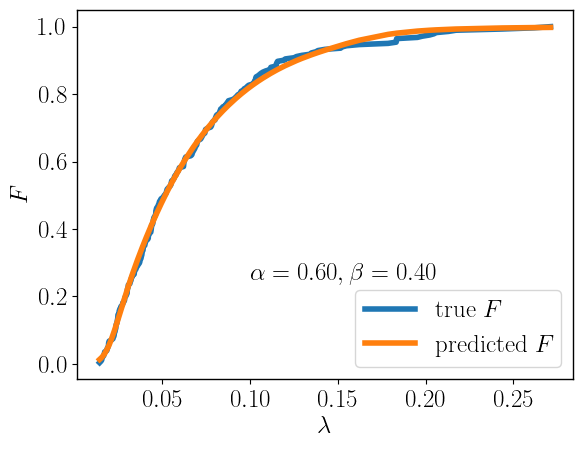

In [272]:
ALPHA=0.6
BETA=0.4
eval_df_single_point, eval_array_single_point = generate_eval_data(alpha=ALPHA,beta=BETA, K=300)
eval_tensor_single_point = torch.Tensor(eval_array_single_point)
CDF_hat = SIR_model_Huber(eval_tensor_single_point).detach().numpy()
lambda_ = eval_df_single_point['li']
true_CDF = eval_df_single_point['true_CDF']

# xmin, xmax = lambda_.min(), lambda_.max()
# ymin, ymax = true_CDF.min(), true_CDF.max()
plt.text(0.1, 0.25, r'$\alpha = %.2f, \beta = %.2f$' % (ALPHA,BETA))
plt.plot(lambda_, true_CDF, label=r'true $F$', linewidth=4)
plt.plot(lambda_, CDF_hat, label = r'predicted $F$',linewidth=4)
plt.ylabel(r'$F$')
plt.xlabel(r'$\lambda$')
plt.legend()
plt.show()

In [273]:
def plot_CDF_agreement(nrows, ncols, model, title):
    fig, ax = plt.subplots(nrows,ncols, figsize=(20,20))
    ax = ax.ravel()
    # alpha_beta_l = [(alpha, beta) for alpha in np.random.uniform(0,1, nrows) for beta in np.random.uniform(0.2,0.7, ncols)]
    N = nrows * ncols
    alpha_l = np.random.uniform(0.22,0.89, N)
    beta_l = np.random.uniform(0.32,0.59, N)
    for ind, (alpha, beta) in enumerate(zip(alpha_l, beta_l)):
        eval_df_single_point, eval_array_single_point = generate_eval_data(alpha=alpha,beta=beta, K=300)
        eval_tensor_single_point = torch.Tensor(eval_array_single_point)
        CDF_hat = model(eval_tensor_single_point).detach().numpy()
        lambda_ = eval_df_single_point['li']
        true_CDF = eval_df_single_point['true_CDF']

        xmin, xmax = lambda_.min(), lambda_.max()
        ymin, ymax = true_CDF.min(), true_CDF.max()
        xwid = (xmax-xmin)/12
        ywid = (ymax-ymin)/12
        xpos = xmin + 4* xwid
        ypos = ymin + 4* ywid
        ax[ind].text(xpos, ypos, r'$\alpha = %.2f, \beta = %.2f$' % (alpha,beta), fontsize=15)
        
        # ax[ind].set_xlim((0,0.26))
        ax[ind].plot(lambda_, true_CDF, label=r'true $F$', linewidth=3, color='blue')
        ax[ind].plot(lambda_, CDF_hat, label = r'predicted $F$',linewidth=3, linestyle='--', color='red')
        ax[ind].set_ylabel(r'$F$')
        ax[ind].set_xlabel(r'$\lambda$')
        ax[ind].legend()
    fig.suptitle(title, fontsize=25)
    plt.tight_layout()
    plt.show()

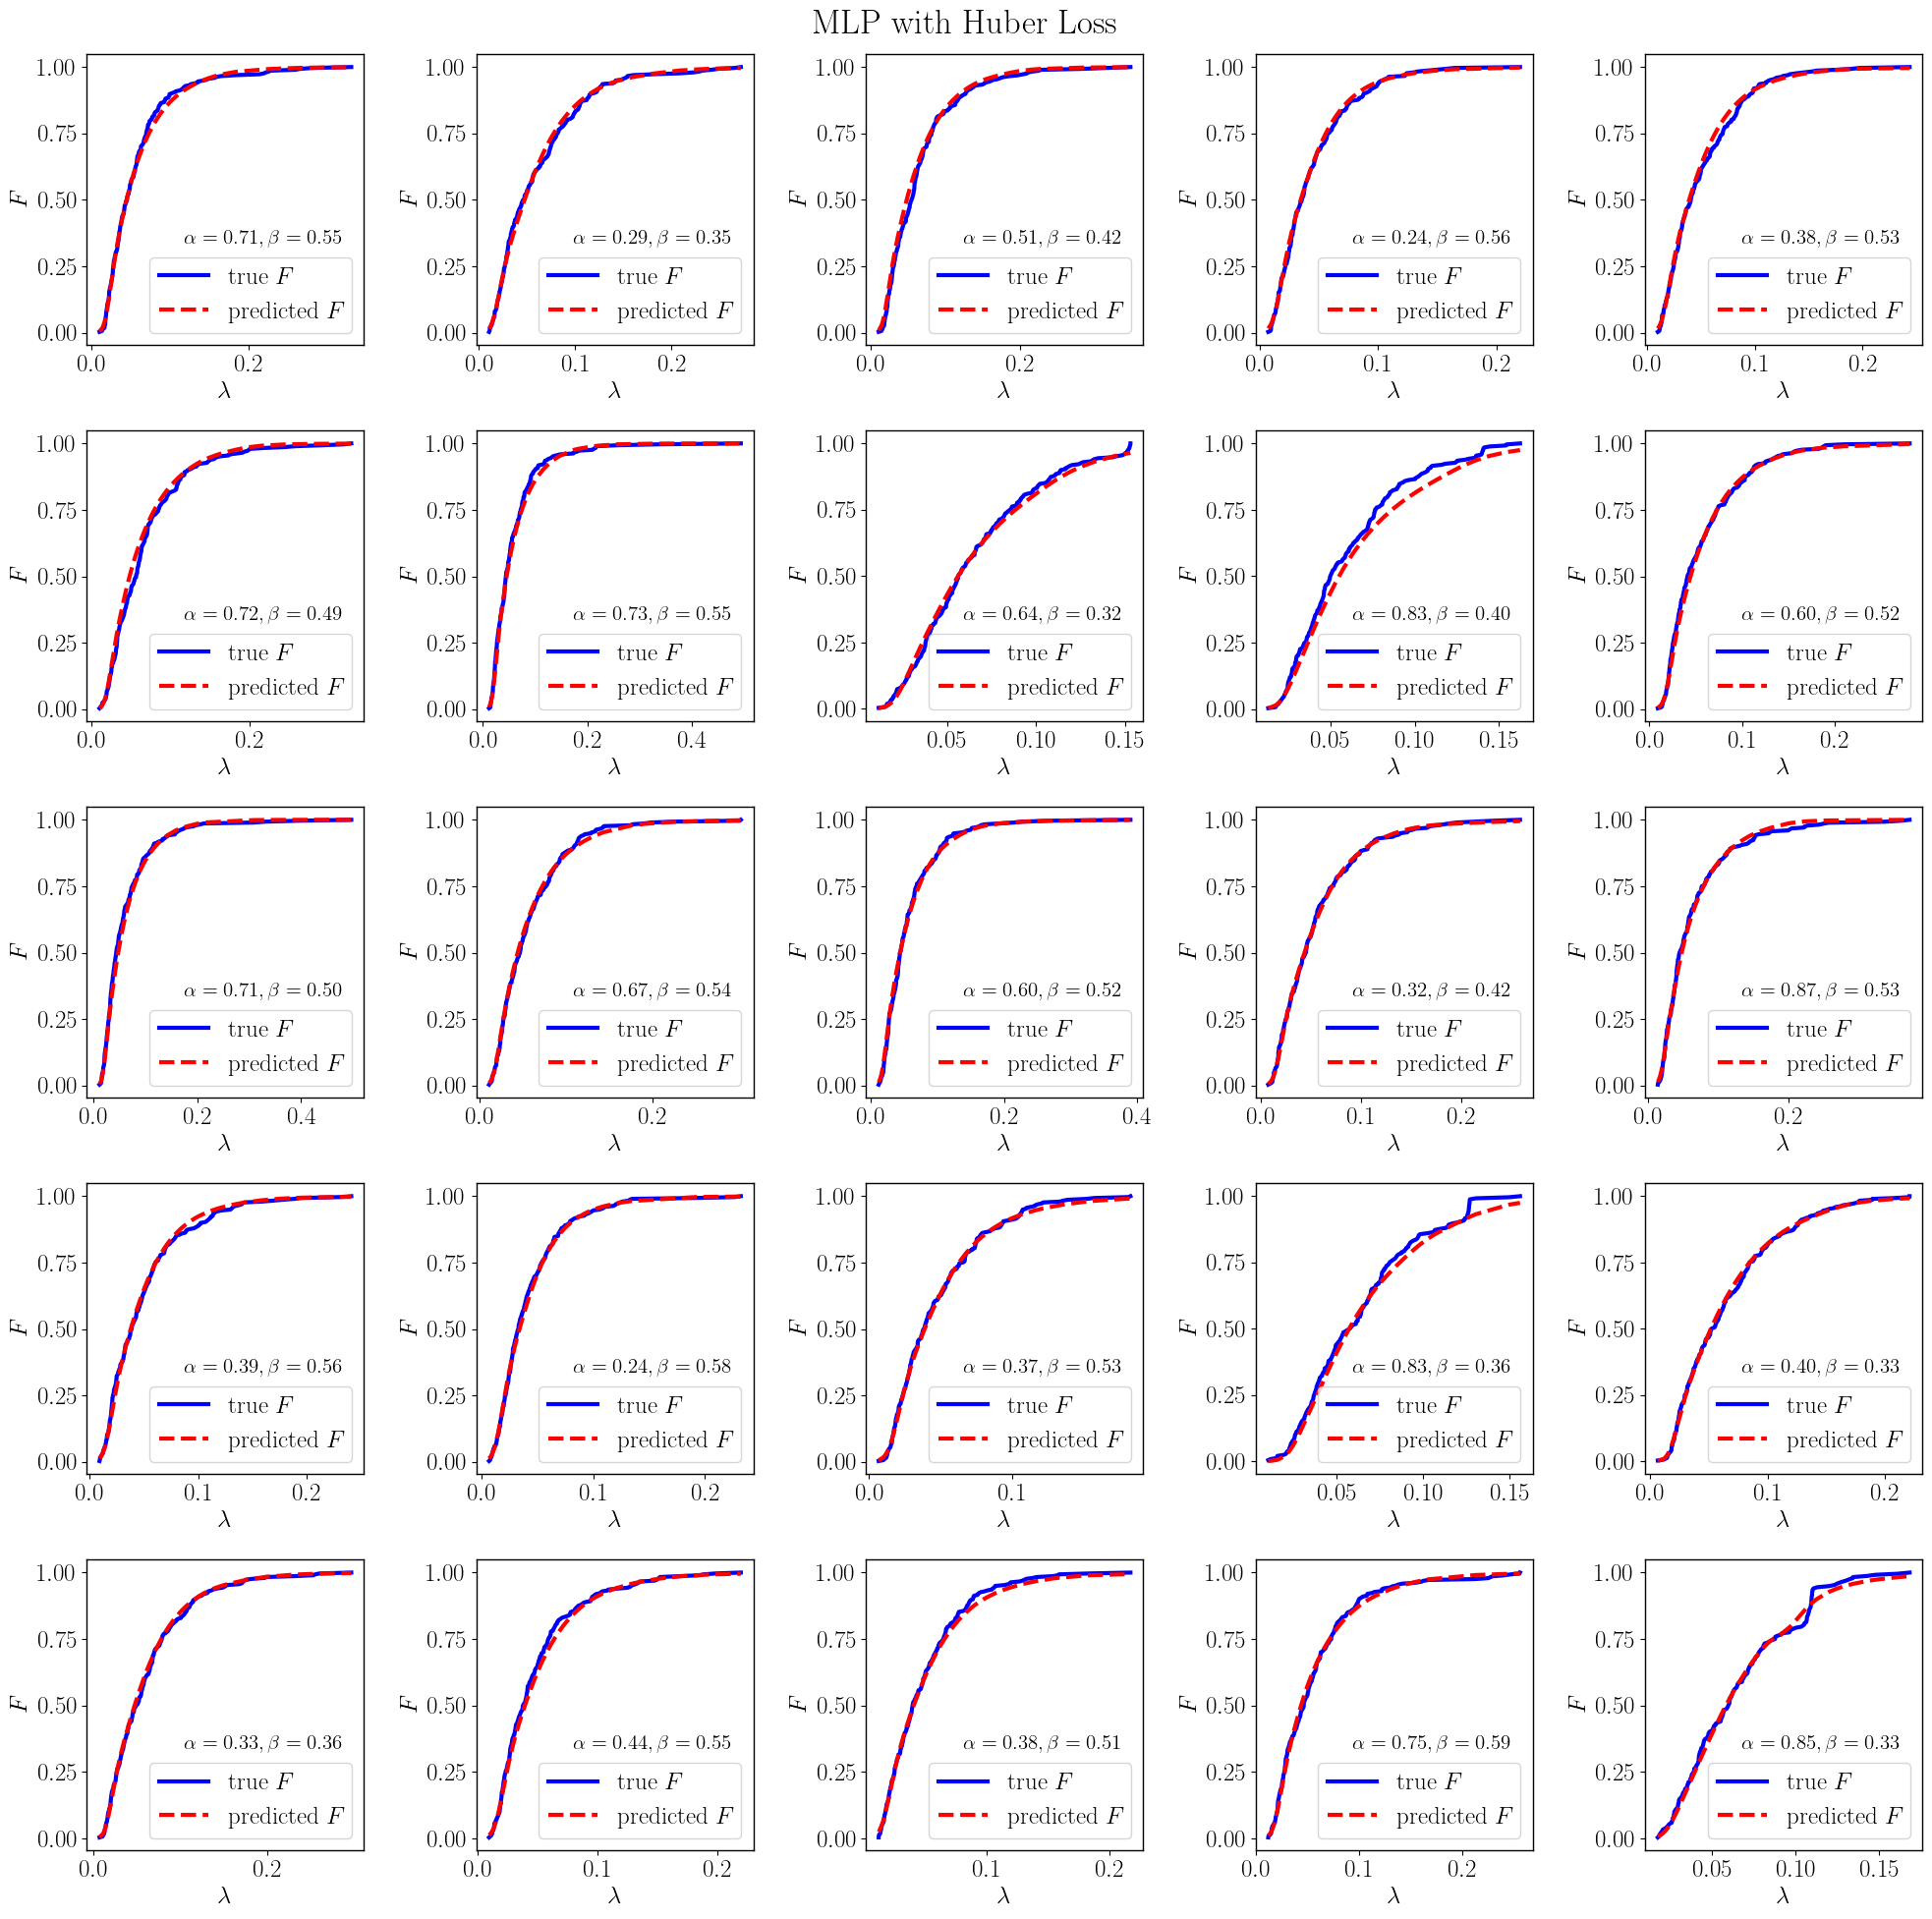

In [274]:
plot_CDF_agreement(nrows=5, ncols=5, model=SIR_model_Huber, title='MLP with Huber Loss')

In [275]:
class TrainedModel:
    def __init__(self, model):
        self.model = model

    def __cdf(self, x):
        # convert to a tensor and compute
 
        X = torch.Tensor(x)#.transpose(1, 0)
            
        X.requires_grad_(True)
        
        self.model.eval() 
        
        return self.model(X), X 
        
    def cdf(self, x): 
        F, _ = self.__cdf(x)
        
        Y = F.detach().numpy()
        if len(Y) == 1:
            Y = Y[0]
        return Y

        
        Y = F.detach().numpy()
        if len(Y) == 1:
            Y = Y[0]
        return Y
    
    def numerical_deriv(self,x):
        h=1E-3
        F_h = self.cdf(x+h)
        F = self.cdf(x)
        deriv = (F_h-F)/h
        return deriv
        

    def pdf(self, x):
        F, X = self.__cdf(x)

        dFdX = torch.autograd.grad(outputs=F, inputs=X, 
                               grad_outputs=torch.ones_like(F),
                               #allow_unused=True, 
                               #retain_graph=True, 
                               create_graph=True)[0]
    
        # Y = dFdX.view(-1).detach().numpy()
        Y = dFdX.detach().numpy()
        if len(Y) == 1:
            Y = Y[0]
        return Y.T[-1]  


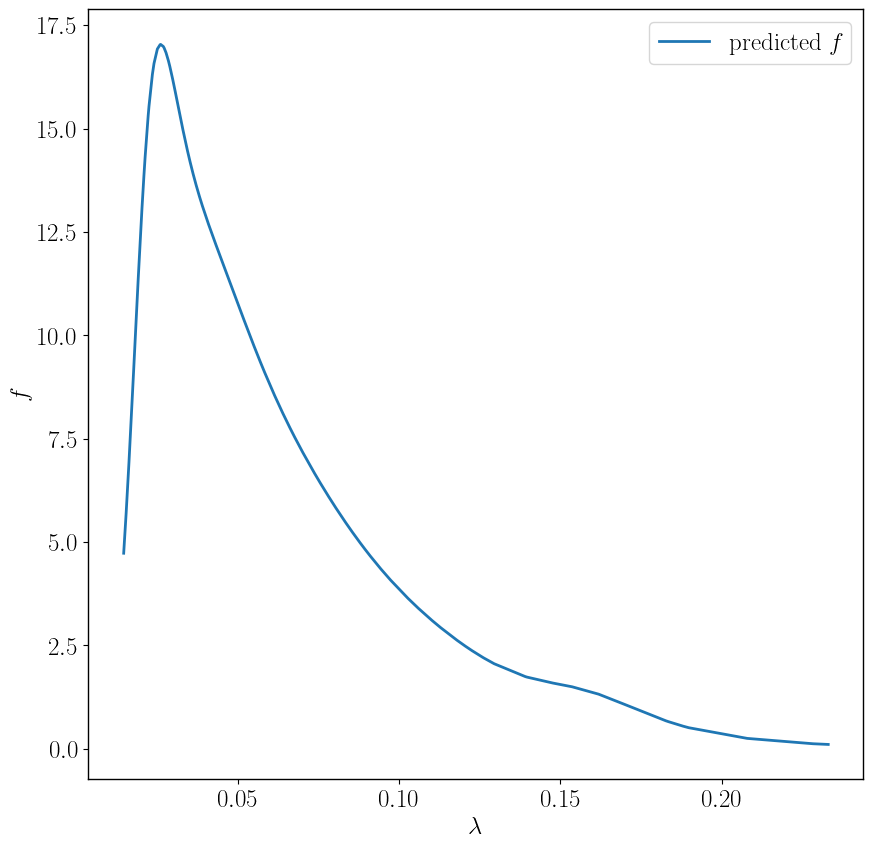

In [276]:
ALPHA=0.6
BETA=0.4
fig, ax = plt.subplots(1,1, figsize=(10,10))
eval_df_single_point, eval_array_single_point = generate_eval_data(alpha=ALPHA,beta=BETA, K=200)
eval_tensor_single_point = torch.Tensor(eval_array_single_point)
tmodel = TrainedModel(SIR_model_Huber)

PDF_hat = tmodel.pdf(eval_tensor_single_point)

lambda_ = eval_df_single_point['li']


# xmin, xmax = lambda_.min(), lambda_.max()
# ymin, ymax = true_CDF.min(), true_CDF.max()
# ax.text(0.1, 0.25, r'$\alpha = %.2f, \beta = %.2f$' % (ALPHA,BETA))

ax.plot(lambda_, PDF_hat, label = r'predicted $f$',linewidth=2)
ax.set_ylabel(r'$f$')
ax.set_xlabel(r'$\lambda$')
ax.legend()
plt.show()

In [277]:
def plot_PDFs(nrows, ncols, model, title):
    fig, ax = plt.subplots(nrows,ncols, figsize=(20,20))
    ax = ax.ravel()
    # alpha_beta_l = [(alpha, beta) for alpha in np.random.uniform(0,1, nrows) for beta in np.random.uniform(0.2,0.7, ncols)]
    N = nrows * ncols
    alpha_l = np.random.uniform(0.22,0.89, N)
    beta_l = np.random.uniform(0.32,0.59, N)
    for ind, (alpha, beta) in enumerate(zip(alpha_l, beta_l)):
        eval_df_single_point, eval_array_single_point = generate_eval_data(alpha=alpha,beta=beta, K=300)
        eval_tensor_single_point = torch.Tensor(eval_array_single_point)
        tmodel = TrainedModel(model)

        PDF_hat = tmodel.pdf(eval_tensor_single_point)

        lambda_ = eval_df_single_point['li']

        xmin, xmax = lambda_.min(), lambda_.max()
        ymin, ymax = PDF_hat.min(), PDF_hat.max()
        xwid = (xmax-xmin)/12
        ywid = (ymax-ymin)/12
        xpos = xmin + 4* xwid
        ypos = ymin + 4* ywid
        ax[ind].text(xpos, ypos, r'$\alpha = %.2f, \beta = %.2f$' % (alpha,beta), fontsize=15)
        ax[ind].plot(lambda_, PDF_hat, label = r'predicted $f =\partial F / \partial \lambda$',linewidth=2)
        ax[ind].set_ylabel(r'$f$')
        ax[ind].set_xlabel(r'$\lambda$')
        ax[ind].legend()
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

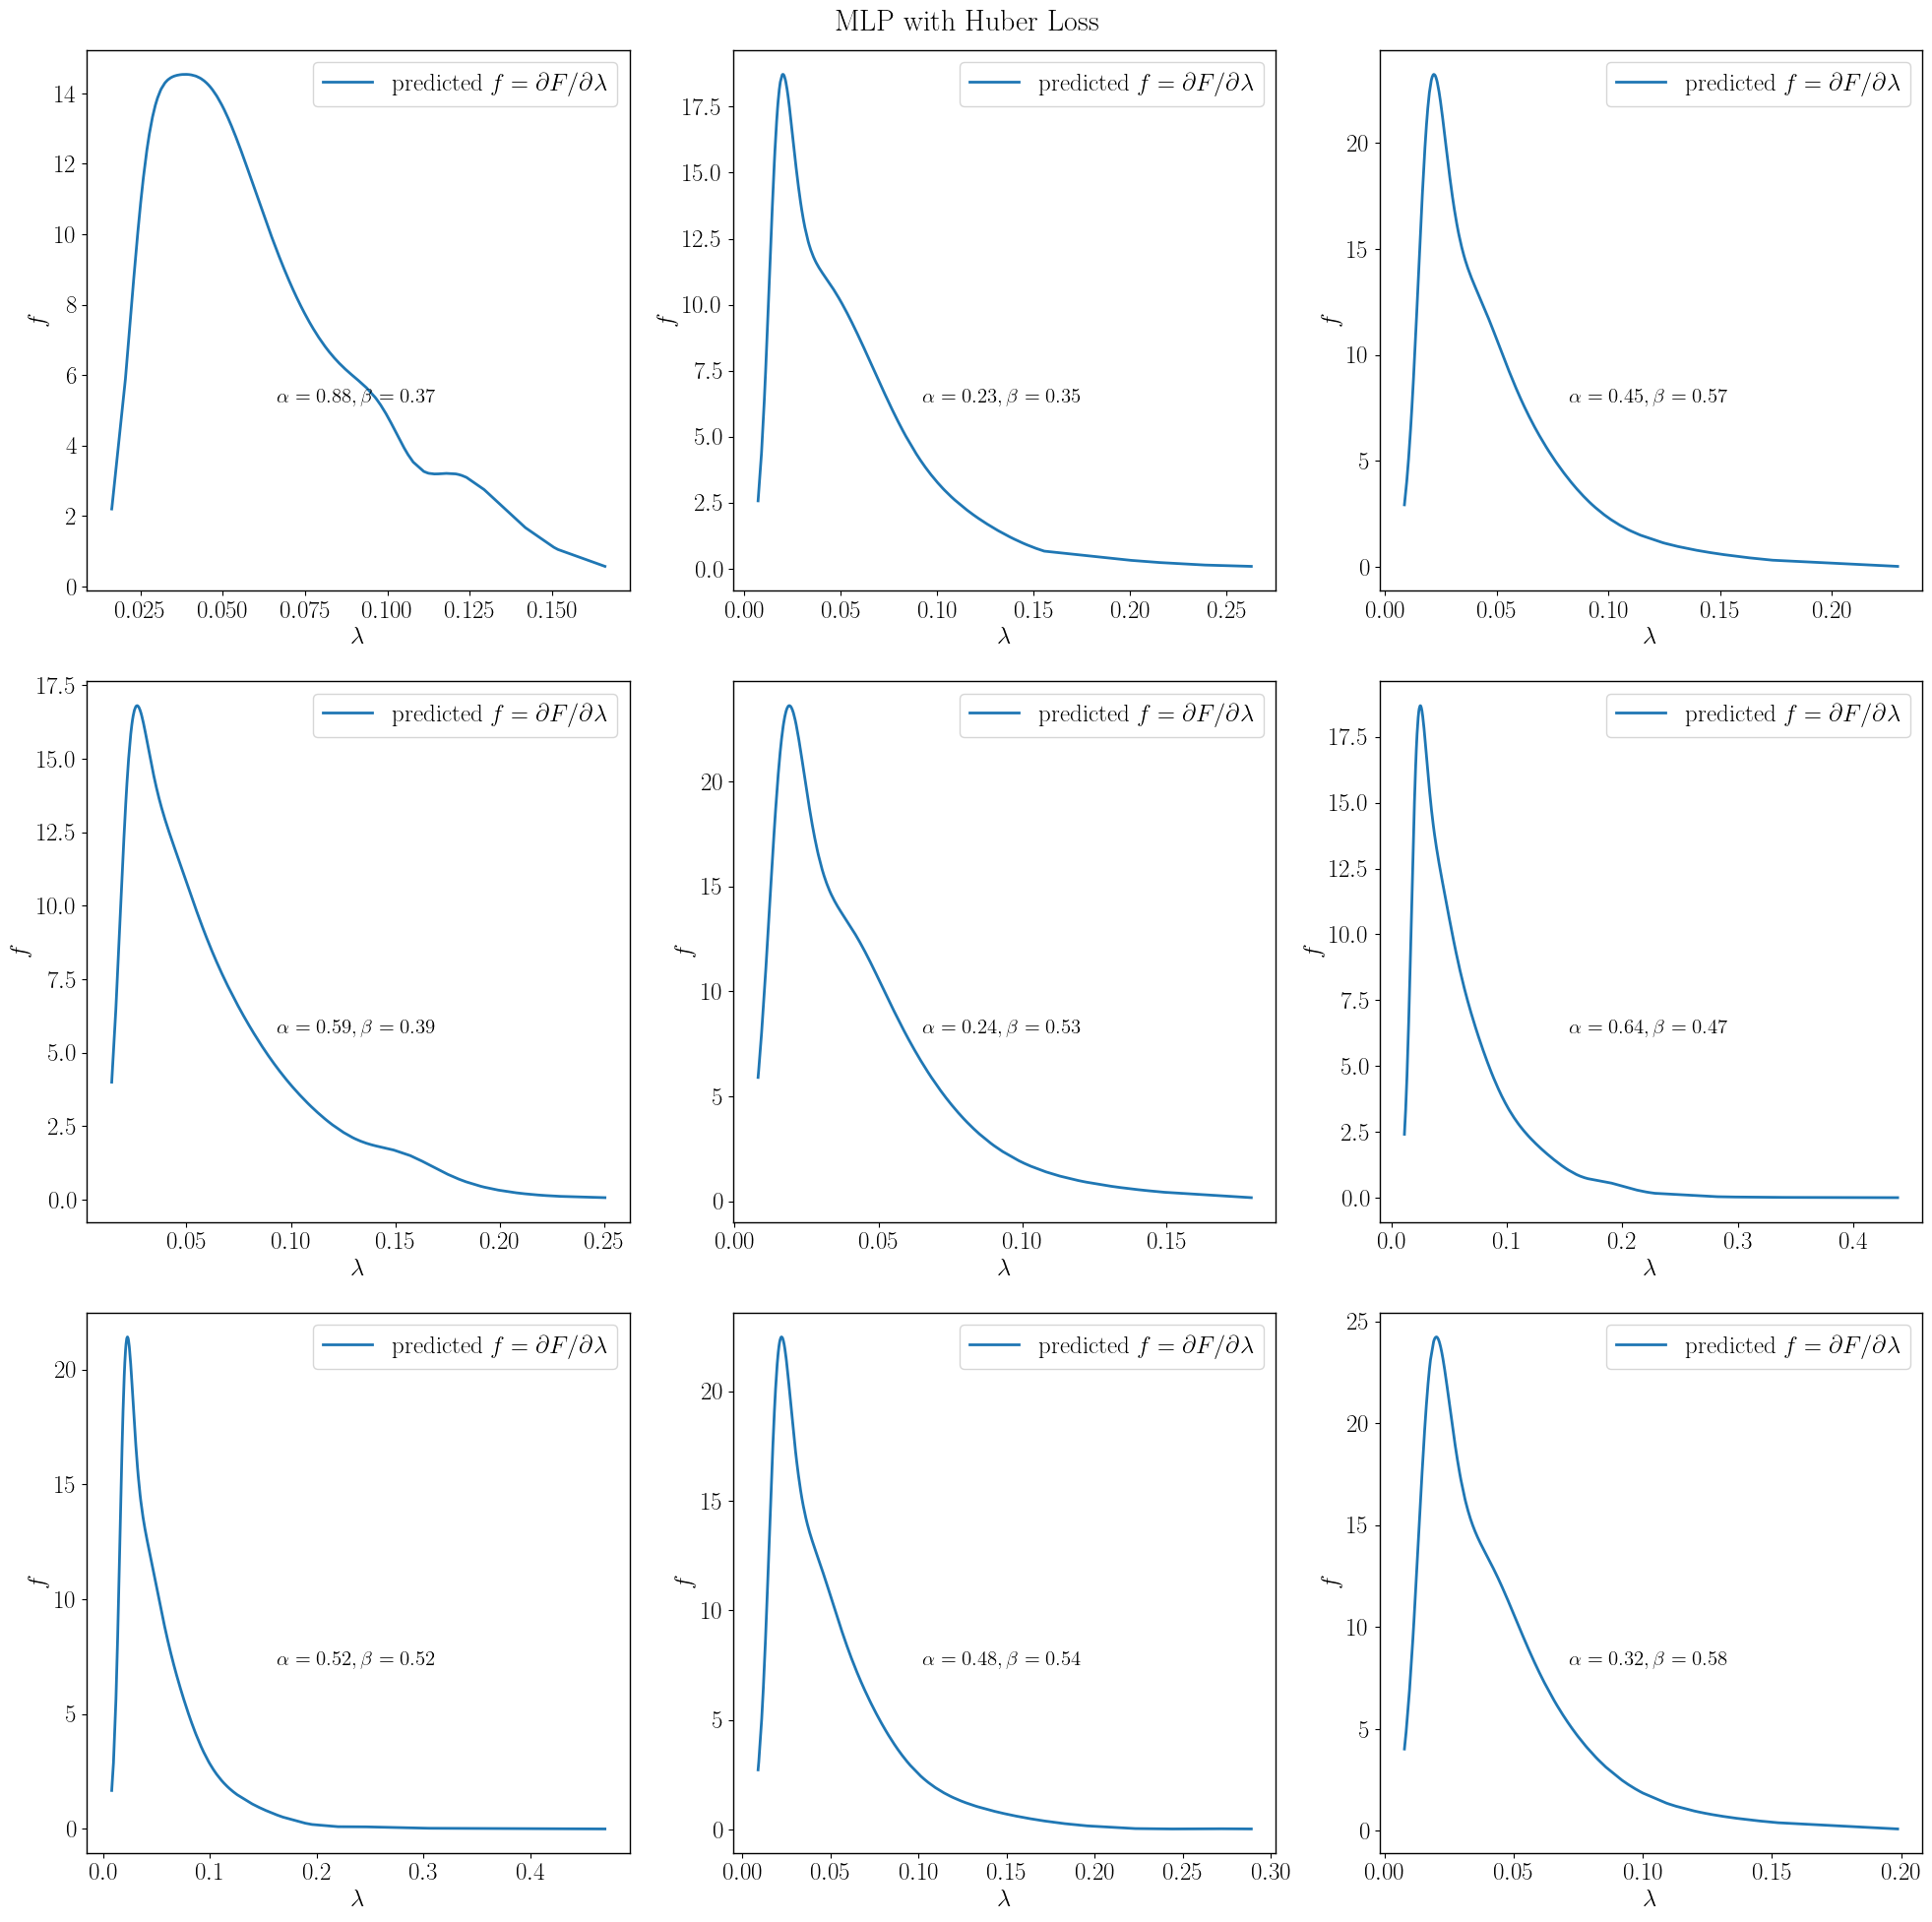

In [278]:
plot_PDFs(nrows=3, ncols=3, model=SIR_model_Huber, title='MLP with Huber Loss')

# train network with average quadratic loss

In [279]:
SIR_Model_avg_quadratic_PARAMS = {
"n_layers": int(5),
"hidden_size": int(10),
"dropout": float(0.13),
"NFEATURES":int(N_Features),
"activation": "SiLU",
'optimizer_name':'NAdam',
    # 'optimizer_name':'RMSprop',
'starting_learning_rate':float(0.00003),
'momentum':float(0.9),
'batch_size':int(60),
'n_iterations': int(3e6),
'traces_step':int(100),
'L2':float(0.1),
'pth_string':'SIR_SILU_Avg_Quadratic_loss.pth'
}

In [280]:
untrained_SIR_model_avg_qaudratic = load_untrained_SIR_model(SIR_Model_avg_quadratic_PARAMS)

BATCHSIZE=SIR_Model_avg_quadratic_PARAMS["batch_size"]
traces_SIR = ([], [], [], [])
traces_step = 2000
optimizer_name=SIR_Model_avg_quadratic_PARAMS["optimizer_name"]


optimizer_SIR = getattr(torch.optim, str(optimizer_name))(untrained_SIR_model_avg_qaudratic.parameters(), 
                                                           lr=SIR_Model_avg_quadratic_PARAMS["starting_learning_rate"])

traces_SIR = train_SIR(model=untrained_SIR_model_avg_qaudratic, 
              optimizer=optimizer_SIR, 
              avloss=average_quadratic_loss,
                            # avloss=Huber_loss,
              batch_size=BATCHSIZE, 
              n_iterations=SIR_Model_avg_quadratic_PARAMS["n_iterations"], 
              traces=traces_SIR, 
              step=traces_step, 
              window=200,
                                            PARAMS=SIR_Model_avg_quadratic_PARAMS,
                      pth_string = SIR_Model_avg_quadratic_PARAMS['pth_string'])

INITIATED UNTRAINED MODEL:
train_t shape =  (90000,) 

train_x shape =  (90000, 3) 

Iteration vs average loss
 iteration	 train-set	 valid-set
saving model with the string : SIR_SILU_Avg_Quadratic_loss.pth


Current valid loss: 0.0871831551194191;  saved better model in models/SIR_SILU_Avg_Quadratic_loss.pth
         0	  0.087226	  0.087183
saving model with the string : SIR_SILU_Avg_Quadratic_loss.pth


Current valid loss: 0.08289839327335358;  saved better model in models/SIR_SILU_Avg_Quadratic_loss.pth
      2000	  0.082790	  0.082898	  0.082898saving model with the string : SIR_SILU_Avg_Quadratic_loss.pth


Current valid loss: 0.08269212394952774;  saved better model in models/SIR_SILU_Avg_Quadratic_loss.pth
      4000	  0.082592	  0.082692	  0.082692saving model with the string : SIR_SILU_Avg_Quadratic_loss.pth


Current valid loss: 0.08238384872674942;  saved better model in models/SIR_SILU_Avg_Quadratic_loss.pth
      6000	  0.082276	  0.082384	  0.082384saving model with the s

In [281]:
# save_model(model = untrained_SIR_model_avg_qaudratic, PARAMS=SIR_Model_avg_quadratic_PARAMS, pth_string=SIR_Model_avg_quadratic_PARAMS['pth_string'])

In [282]:
SIR_model_Average_Quadratic = load_model(untrained_SIR_model_avg_qaudratic, SIR_Model_avg_quadratic_PARAMS, SIR_Model_avg_quadratic_PARAMS['pth_string'])

INITIATED MODEL: SIR_Model(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): SiLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): SiLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): SiLU()
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): SiLU()
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): SiLU()
    (10): Linear(in_features=10, out_features=1, bias=True)
    (11): Sigmoid()
  )
)
loading model with th string : SIR_SILU_Avg_Quadratic_loss.pth



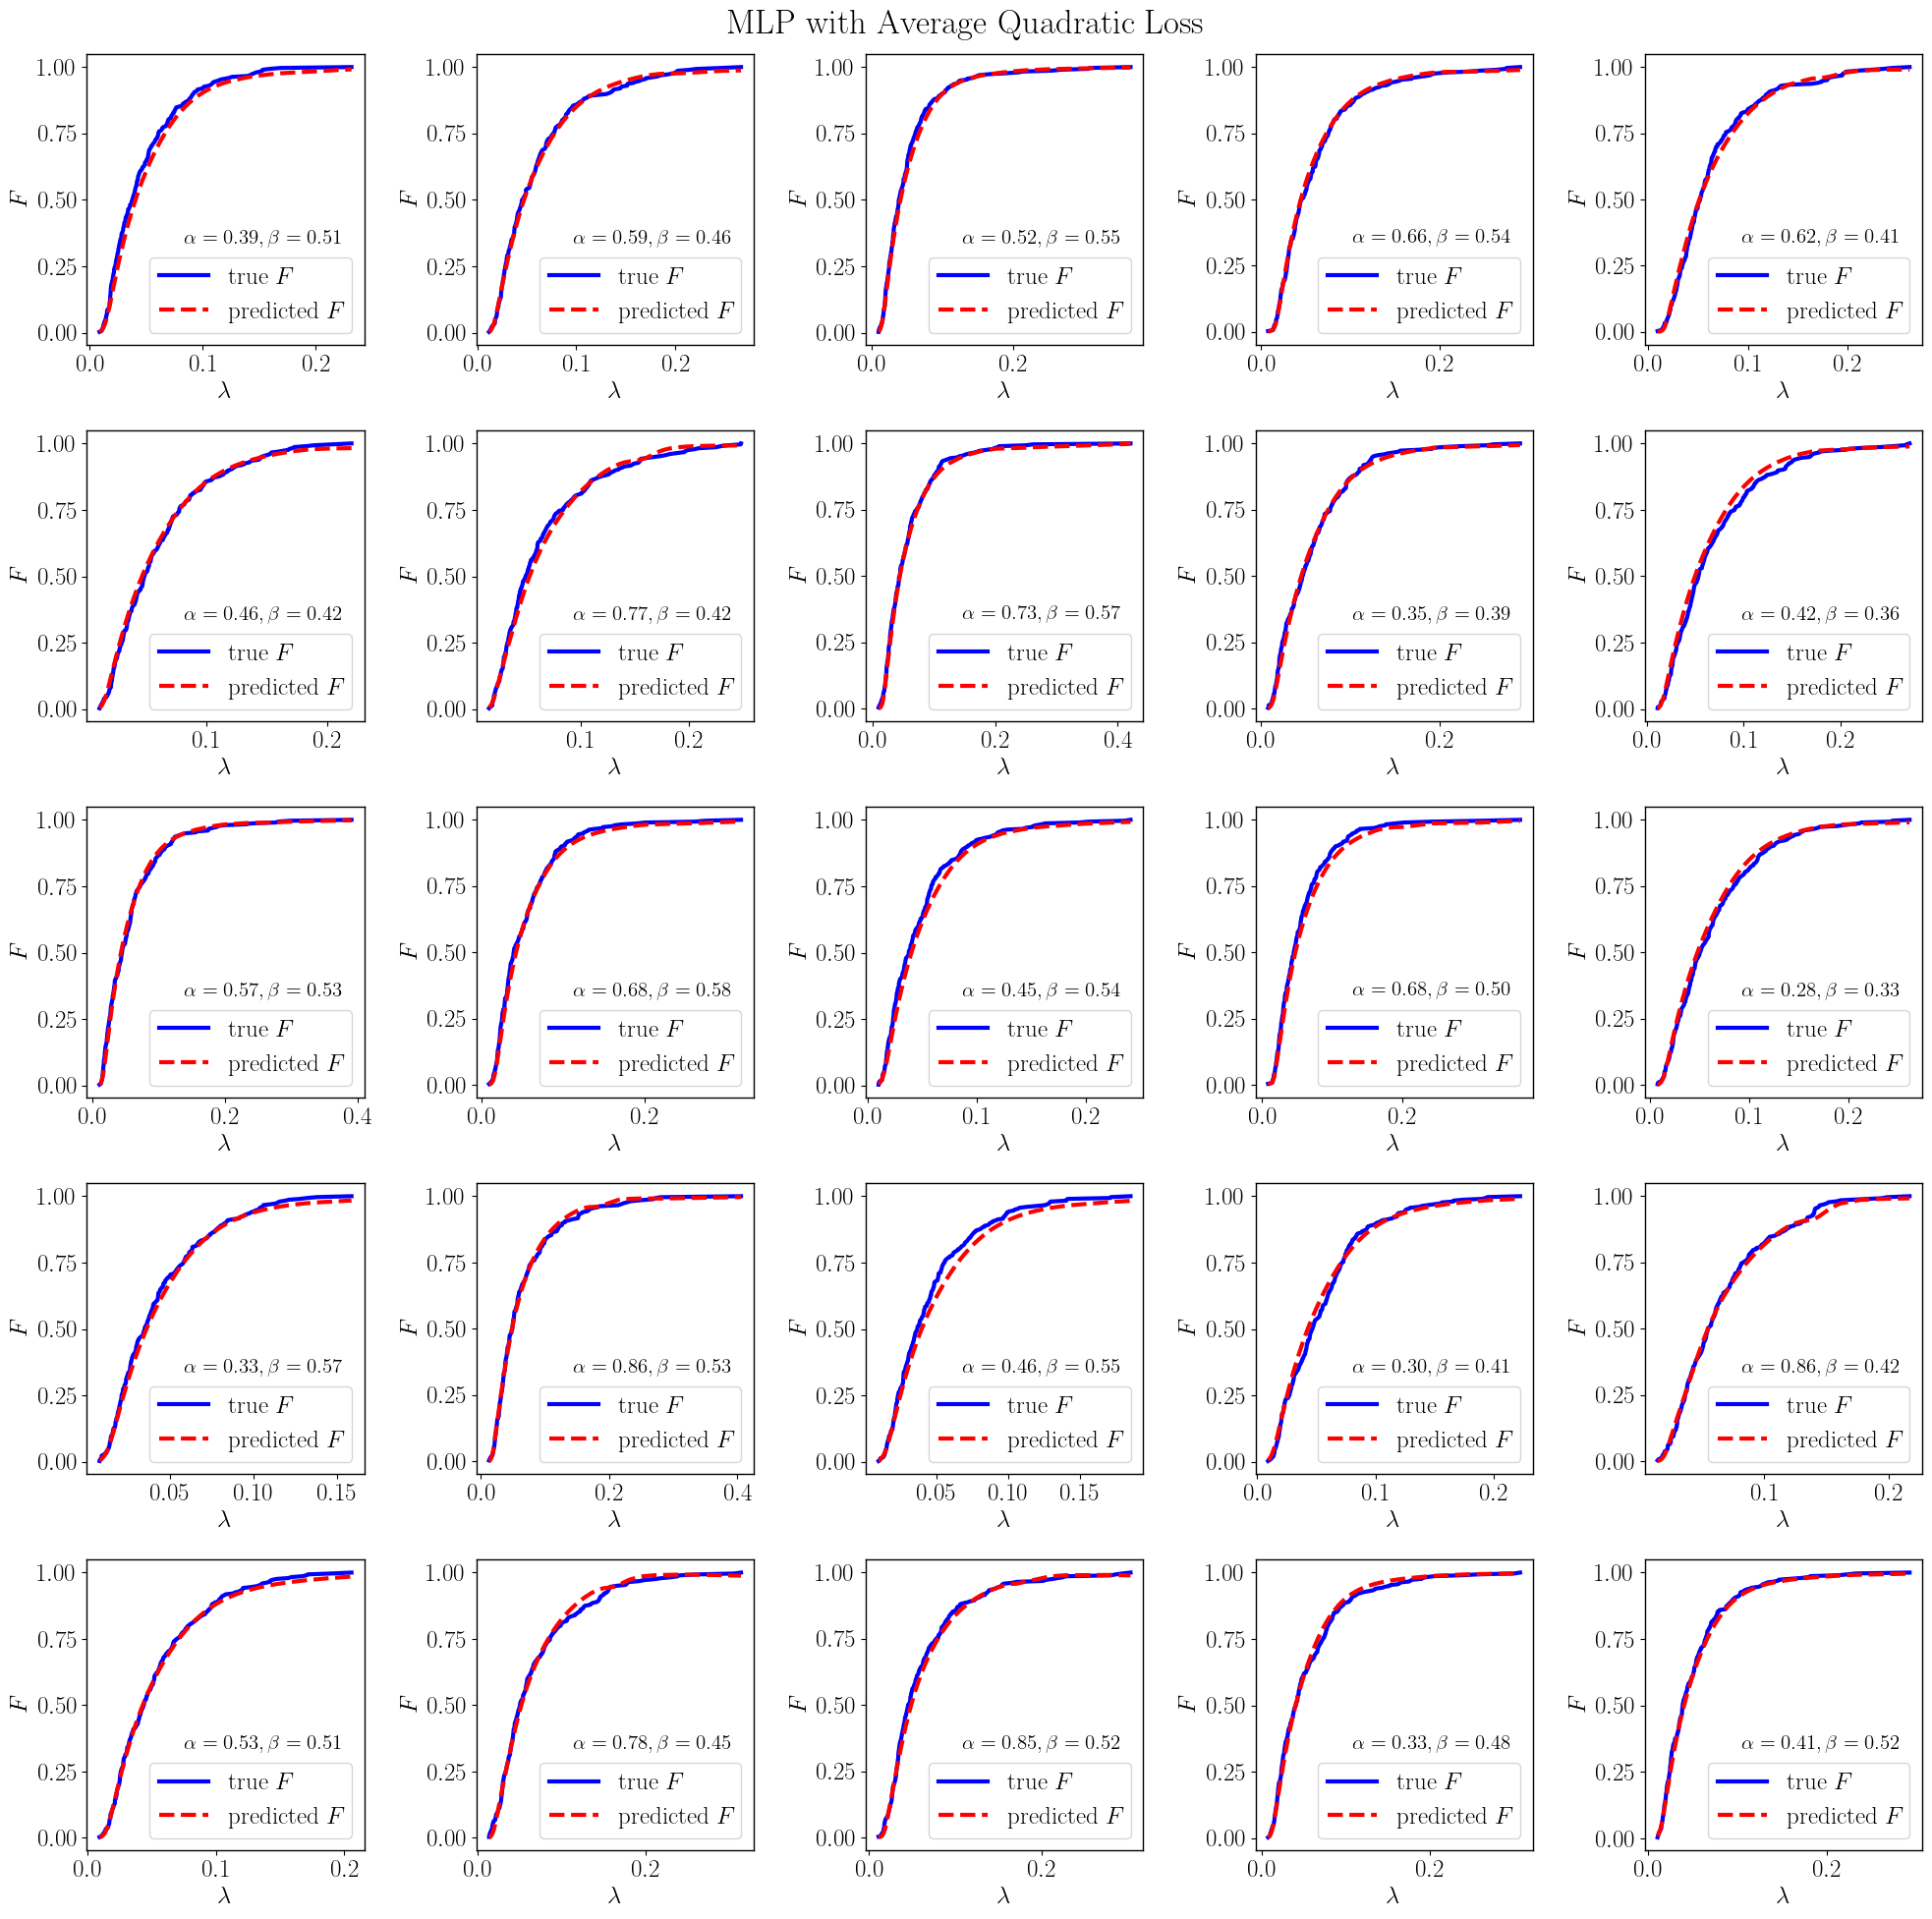

In [283]:
plot_CDF_agreement(nrows=5, ncols=5, model=SIR_model_Average_Quadratic,title='MLP with Average Quadratic Loss')

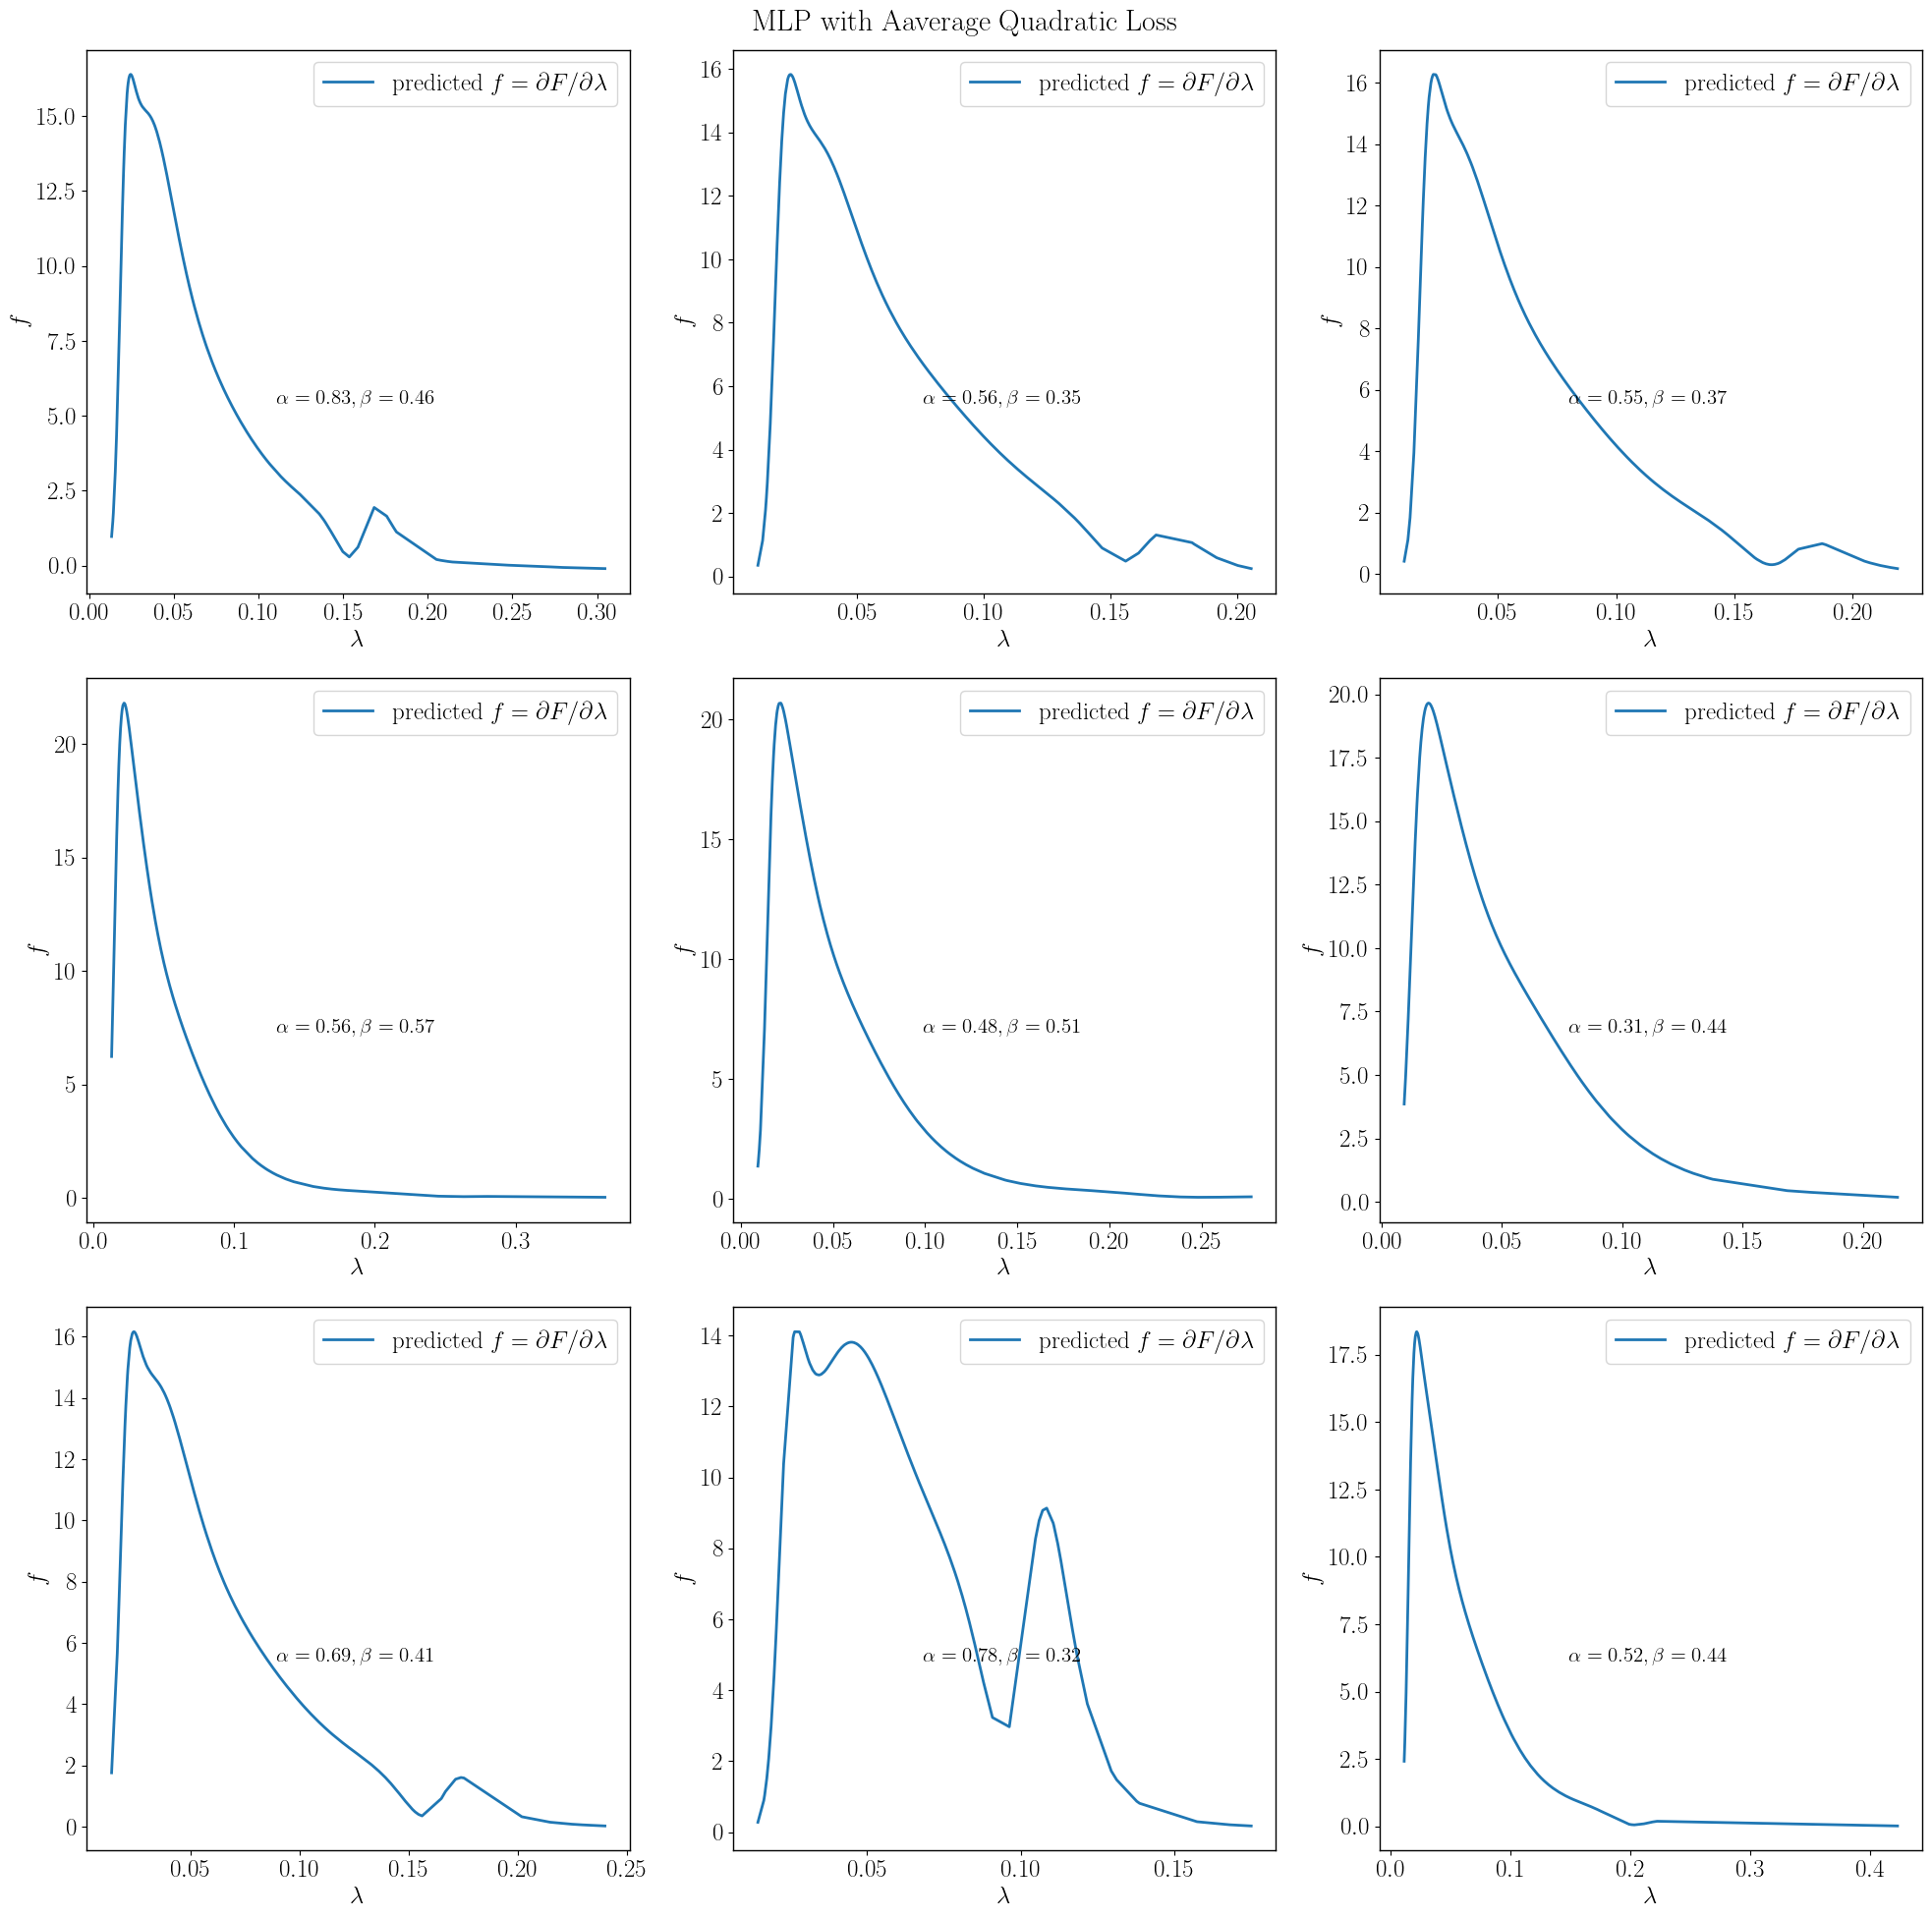

In [284]:
plot_PDFs(nrows=3, ncols=3, model=SIR_model_Average_Quadratic, title='MLP with Aaverage Quadratic Loss')

# Plot Conformal Inference confidence band

In [518]:
SIR_model_Huber = load_model(untrained_SIR_model_Huber, SIR_Model_Huber_PARAMS, SIR_Model_Huber_PARAMS['pth_string'])
ALPHA=0.6
BETA=0.4
np.random.seed(300)
X_val_df, X_val_arr = generate_eval_data(alpha=ALPHA,beta=BETA, K=100)
X_val_df

INITIATED MODEL: SIR_Model(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): SiLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): SiLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): SiLU()
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): SiLU()
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): SiLU()
    (10): Linear(in_features=10, out_features=1, bias=True)
    (11): Sigmoid()
  )
)
loading model with th string : SIR_SILU_Huber_loss.pth



,alpha,beta,li,true_CDF
75,0.6,0.4,0.012931,0.010526
82,0.6,0.4,0.013245,0.021053
67,0.6,0.4,0.015148,0.031579
52,0.6,0.4,0.015931,0.042105
32,0.6,0.4,0.016240,0.052632
...,...,...,...,...
90,0.6,0.4,0.184153,0.957895
60,0.6,0.4,0.185767,0.968421
78,0.6,0.4,0.223401,0.978947
77,0.6,0.4,0.223420,0.989474


In [519]:
eval_tensor_single_point = torch.Tensor(X_val_arr)
CDF_hat = SIR_model_Huber(eval_tensor_single_point).view(-1).detach().numpy().flatten()
lambda_ = X_val_df['li'].to_numpy()
CDF_true = X_val_df['true_CDF'].to_numpy().flatten()

In [520]:
CDF_true.shape, CDF_hat.shape

((95,), (95,))

In [529]:
Ncal = len(CDF_true)
alpha=0.1
alpha_freq = np.ceil((Ncal+1)*(1-alpha))/Ncal
scores = np.abs(CDF_true-CDF_hat)
print(scores.mean(), scores.std())

0.033662537155760626 0.019672004501386044


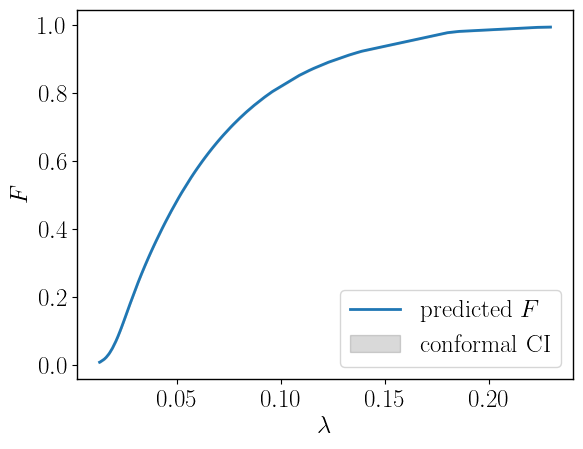

Coverage of 0.0


In [530]:

qhat = np.quantile(scores, alpha_freq)


# plt.ylim(ymin,ymax)
plt.plot(lambda_, CDF_hat, label = r'predicted $F$',linewidth=2)
plt.ylabel(r'$F$')
plt.xlabel(r'$\lambda$')
lower_bound = np.array(CDF_hat-qhat)
offset = np.where(lower_bound < 0, - lower_bound, 0)
lower_bound += offset

upper_bound = np.array(CDF_hat+qhat)
offset = np.where(upper_bound > 1, 1- upper_bound, 0)
upper_bound += offset

plt.fill_between(lambda_, y1=lower_bound, y2=upper_bound, color='k', alpha=0.15, label = 'conformal CI')

plt.legend()
plt.show()


def calculate_coverage(lower_bound,upper_bound,y_true):
    out_of_bound=0
    N=len(y_true)
    
    for i in range(N):
        if y_true[i]<lower_bound[i] or y_true[i]>upper_bound[i]:
            out_of_bound+=1
            
    return 1-out_of_bound/N

print('Coverage of {}'.format(calculate_coverage(CDF_hat-qhat,CDF_hat+qhat,CDF_true)))

# Fluctuate model parameters

In [504]:
from collections import OrderedDict
SIR_model_Huber = load_model(untrained_SIR_model_Huber, SIR_Model_Huber_PARAMS, SIR_Model_Huber_PARAMS['pth_string'])
parameters_dict = OrderedDict(SIR_model_Huber.state_dict())
# print(parameters_dict['model.0.weight'])
print(parameters_dict['model.0.weight'])

INITIATED MODEL: SIR_Model(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): SiLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): SiLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): SiLU()
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): SiLU()
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): SiLU()
    (10): Linear(in_features=10, out_features=1, bias=True)
    (11): Sigmoid()
  )
)
loading model with th string : SIR_SILU_Huber_loss.pth

tensor([[-0.0284,  1.1196, -1.8972],
        [ 0.6205, -0.3870,  1.6512],
        [ 0.0887, -0.6329,  0.9125],
        [-0.0878,  0.9749,  1.3254],
        [-0.2405,  0.7973, -1.1150],
        [ 0.0772, -0.2609,  1.3585],
        [-0.1117,  0.1987,  1.6990],
        [ 0.1978, -1.0234,  1.4164],
        [-0.5049,  0.1937,  1.3020],
        [-0.0366, -0.1672,  1.2362]])


In [646]:
SIR_model_Huber.state_dict()

OrderedDict([('model.0.weight',
              tensor([[-0.0284,  1.1196, -1.8972],
                      [ 0.6205, -0.3870,  1.6512],
                      [ 0.0887, -0.6329,  0.9125],
                      [-0.0878,  0.9749,  1.3254],
                      [-0.2405,  0.7973, -1.1150],
                      [ 0.0772, -0.2609,  1.3585],
                      [-0.1117,  0.1987,  1.6990],
                      [ 0.1978, -1.0234,  1.4164],
                      [-0.5049,  0.1937,  1.3020],
                      [-0.0366, -0.1672,  1.2362]])),
             ('model.0.bias',
              tensor([ 1.0231,  0.5450, -0.6022,  0.6509, -0.1953,  0.1416,  0.0611,  0.3163,
                       0.0933,  0.6342])),
             ('model.2.weight',
              tensor([[ 0.0824,  0.3024, -0.2404,  0.7662, -0.4618,  0.9587,  1.3793, -0.1901,
                        0.2219,  0.8261],
                      [-0.3750, -0.1226, -0.4030, -0.0249,  0.6411,  0.6023,  0.9479,  0.1700,
                        

In [679]:
def visualize_weights():
    from collections import OrderedDict
    SIR_model_Huber = load_model(untrained_SIR_model_Huber, SIR_Model_Huber_PARAMS, SIR_Model_Huber_PARAMS['pth_string'])
    parameters_dict = OrderedDict(SIR_model_Huber.state_dict())
    fig, axs = plt.subplots(3,4, figsize=(15,7))
    axs = axs.ravel()
    print(len(parameters_dict))
    for ind, key in enumerate(parameters_dict):
        
        weights =parameters_dict[key].detach().numpy()
        axs[ind].hist(weights.flatten(), label=key)
        axs[ind].legend(fontsize=13)

        
        
    plt.tight_layout()
    plt.show()

INITIATED MODEL: SIR_Model(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): SiLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): SiLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): SiLU()
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): SiLU()
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): SiLU()
    (10): Linear(in_features=10, out_features=1, bias=True)
    (11): Sigmoid()
  )
)
loading model with th string : SIR_SILU_Huber_loss.pth

12


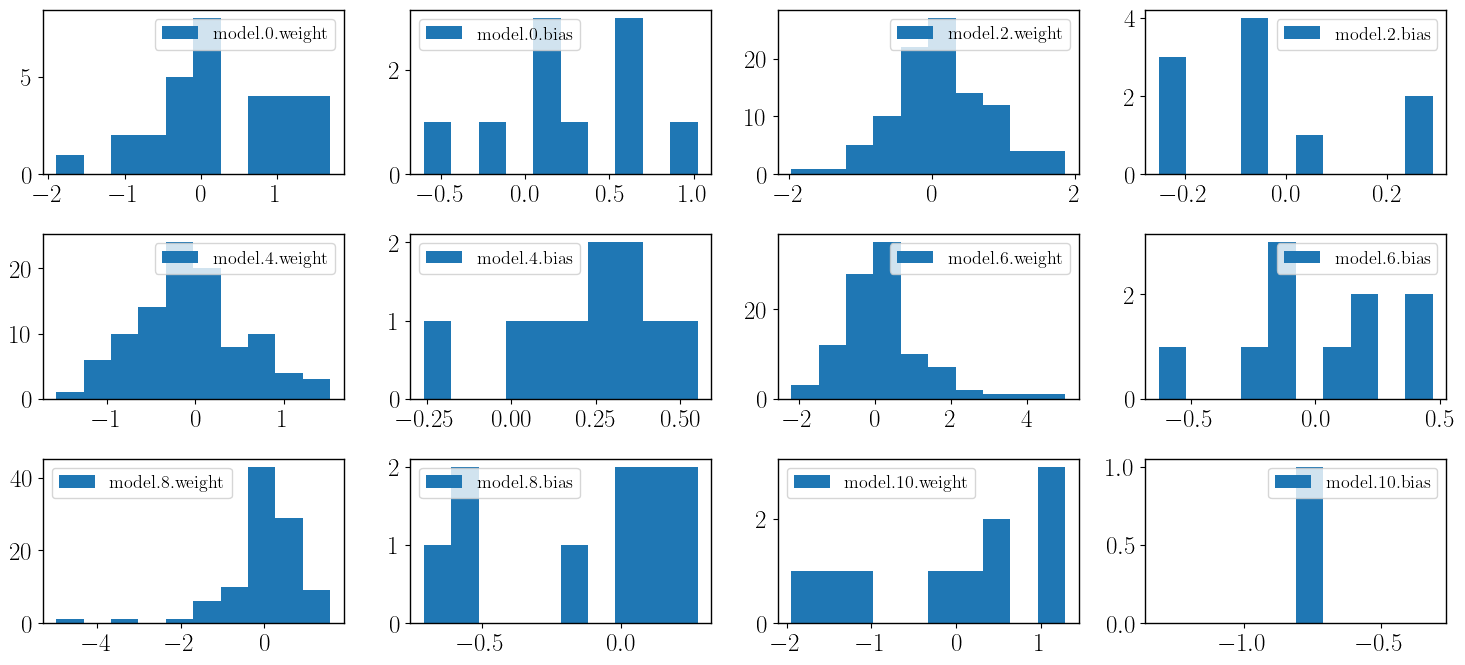

In [680]:
visualize_weights()

In [524]:
def fluctuate_model(std):
    from collections import OrderedDict
    SIR_model_Huber = load_model(untrained_SIR_model_Huber, SIR_Model_Huber_PARAMS, SIR_Model_Huber_PARAMS['pth_string'])
    eval_tensor_single_point = torch.Tensor(X_val_arr)

    CDF_hat = SIR_model_Huber(eval_tensor_single_point).view(-1).detach().numpy().flatten()
    CDF_true = X_val_df['true_CDF'].to_numpy().flatten()
    lambda_ = X_val_df['li'].to_numpy()
    plt.plot(lambda_, CDF_hat, label = r'$\hat{F}$ base Huber model', linewidth = 3,color='k')
    plt.plot(lambda_, CDF_true, label = r'true $F$', linewidth = 3)
    plt.ylabel(r'$F$')
    plt.xlabel(r'$\lambda$')
    plt.text(0.17,0.4,r'$\sigma = %.3f$' % std)
    parameters_dict = OrderedDict(SIR_model_Huber.state_dict())
    
    K=100
    for i in range(K):
        fluctuated_params_dict=OrderedDict()
        for key in parameters_dict:
            fluctuated_params_dict[key]=torch.normal(mean=parameters_dict[key], std=std)
        SIR_model_Huber.load_state_dict(fluctuated_params_dict)

        CDF_hat_fluctuated = SIR_model_Huber(eval_tensor_single_point).view(-1).detach().numpy()
        plt.plot(lambda_, CDF_hat_fluctuated, alpha=0.1, linewidth=2)
    plt.legend()
    plt.show()


INITIATED MODEL: SIR_Model(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): SiLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): SiLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): SiLU()
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): SiLU()
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): SiLU()
    (10): Linear(in_features=10, out_features=1, bias=True)
    (11): Sigmoid()
  )
)
loading model with th string : SIR_SILU_Huber_loss.pth



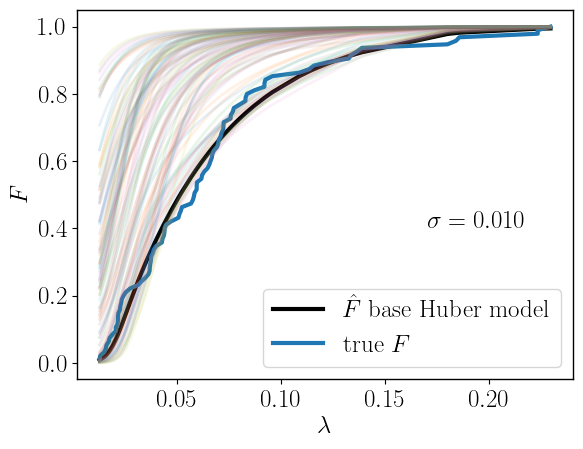

In [525]:
fluctuate_model(std=0.01)

INITIATED MODEL: SIR_Model(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): SiLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): SiLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): SiLU()
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): SiLU()
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): SiLU()
    (10): Linear(in_features=10, out_features=1, bias=True)
    (11): Sigmoid()
  )
)
loading model with th string : SIR_SILU_Huber_loss.pth



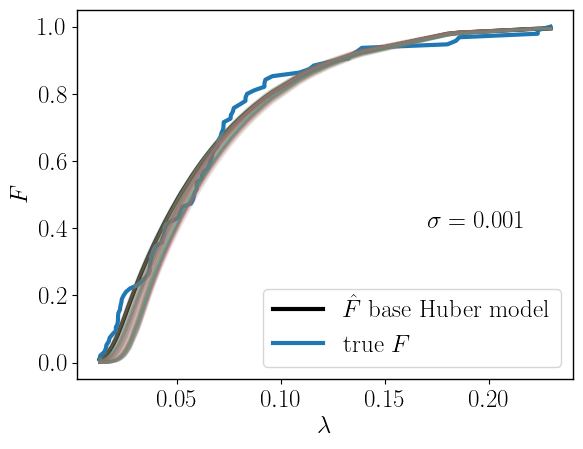

In [526]:
fluctuate_model(std=0.001)

INITIATED MODEL: SIR_Model(
  (model): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): SiLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): SiLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): SiLU()
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): SiLU()
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): SiLU()
    (10): Linear(in_features=10, out_features=1, bias=True)
    (11): Sigmoid()
  )
)
loading model with th string : SIR_SILU_Huber_loss.pth



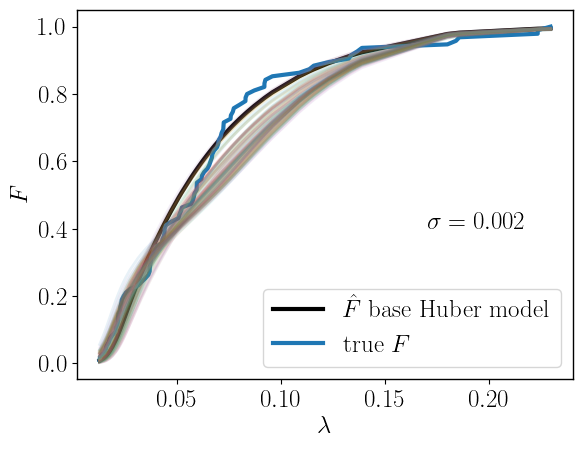

In [527]:
fluctuate_model(std=0.002)

# Plot CDF Residuals and Compare RMS of Huber model and average quadratic model

In [621]:
def plot_CDF_residuals(nrows, ncols, model, title, show_plot=True):
    fig, ax = plt.subplots(nrows,ncols, figsize=(10,10))
    ax = ax.ravel()
    # alpha_beta_l = [(alpha, beta) for alpha in np.random.uniform(0,1, nrows) for beta in np.random.uniform(0.2,0.7, ncols)]
    N = nrows * ncols
    alpha_l = np.random.uniform(0.22,0.89, N)
    beta_l = np.random.uniform(0.32,0.59, N)
    K=100
    all_residuals = []
    for ind, (alpha, beta) in enumerate(zip(alpha_l, beta_l)):
        eval_df_single_point, eval_array_single_point = generate_eval_data(alpha=alpha,beta=beta, K=K)
        eval_tensor_single_point = torch.Tensor(eval_array_single_point)
        CDF_hat = model(eval_tensor_single_point).view(-1).detach().numpy().flatten()
        lambda_ = eval_df_single_point['li'].to_numpy().flatten()
        true_CDF = eval_df_single_point['true_CDF'].to_numpy().flatten()
        residual = true_CDF - CDF_hat
        all_residuals.append(residual)
        
        xmin, xmax = lambda_.min(), lambda_.max()
        ymin, ymax = residual.min(), residual.max()
        xwid = (xmax-xmin)/12
        ywid = (ymax-ymin)/12
        xpos = xmin + 4* xwid
        ypos = ymin + 4* ywid
        ax[ind].text(xpos, ypos, r'$\alpha = %.2f, \beta = %.2f$' % (alpha,beta), fontsize=15)
        
        # ax[ind].set_xlim((0,0.26))
        ax[ind].plot(lambda_, residual, label=r'true $F$ - predicted $F$', linewidth=3, color='blue')
        ax[ind].set_ylabel(r'$F$')
        ax[ind].set_xlabel(r'$\lambda$')
        ax[ind].legend()
    fig.suptitle(title, fontsize=25)
    plt.tight_layout()
    if show_plot:
        plt.show()
    return all_residuals

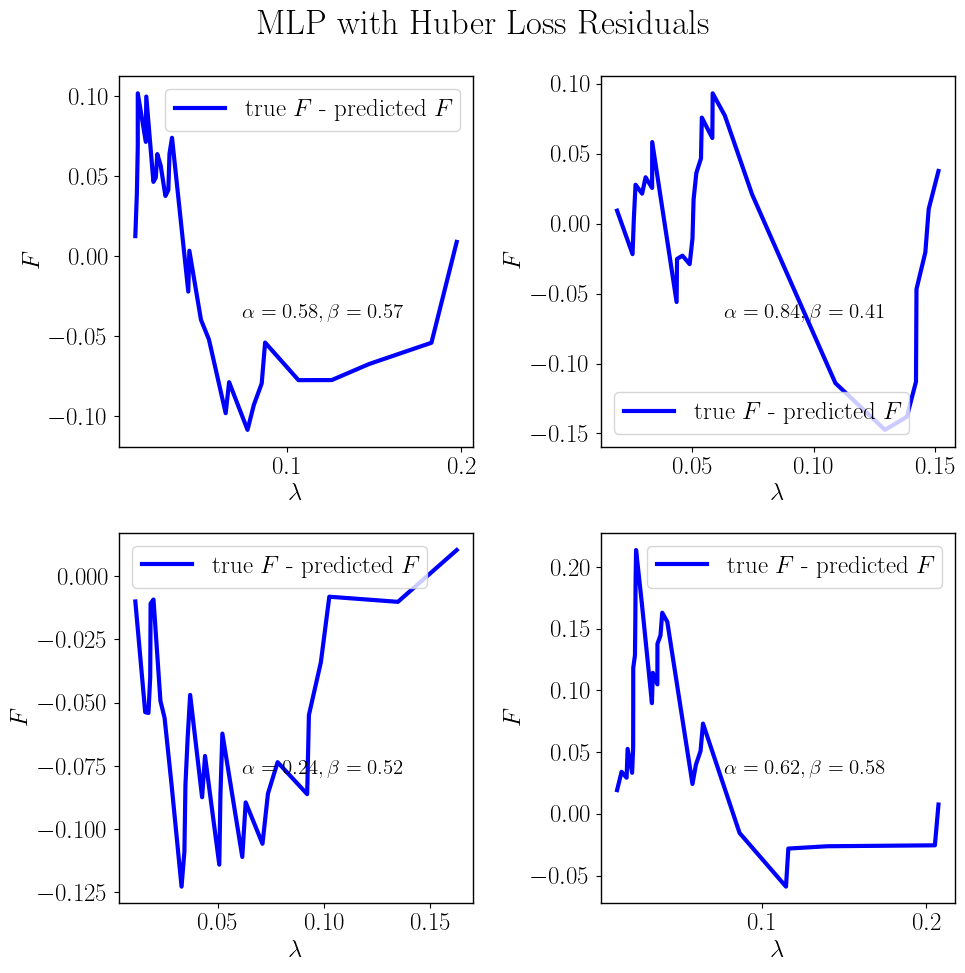

In [617]:
all_residuals_Huber = plot_CDF_residuals(nrows=2, ncols=2, model=SIR_model_Huber, title='MLP with Huber Loss Residuals')

In [622]:
all_residuals_Huber = plot_CDF_residuals(nrows=10, ncols=10, model=SIR_model_Huber, title='MLP with Huber Loss Residuals', show_plot=False)

/tmp/ipykernel_1855342/3674419889.py:33: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


In [623]:
all_residuals_average_quadratic = plot_CDF_residuals(nrows=10, ncols=10, model=SIR_model_Average_Quadratic, title='MLP with Average Quadratic Loss Residuals', show_plot=False)

/tmp/ipykernel_1855342/3674419889.py:33: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


(100, 100)
[0.01542744 0.0159734  0.01742512 0.02011308 0.02054131 0.02189517
 0.02352362 0.02426922 0.02521324 0.0276798  0.02936767 0.03074119
 0.03233695 0.03452043 0.03449248 0.03502682 0.03612815 0.039091
 0.0404335  0.04126636 0.04179054 0.04171773 0.04244283 0.0428556
 0.04229982 0.042346   0.04472837 0.04757809 0.04927306 0.04999146
 0.05033432 0.05086669 0.05057198 0.05147442 0.05538154 0.05498183
 0.05475438 0.0550612  0.0559316  0.05602949 0.05566719 0.05655843
 0.0555916  0.05677161 0.05667614 0.05704296 0.05857245 0.05976957
 0.05893116 0.05879919 0.05817685 0.05829215 0.05627287 0.05529358
 0.05567015 0.05479065 0.05557412 0.05495104 0.05621294 0.05718093
 0.05810956 0.05756331 0.0573529  0.05683413 0.05965719 0.06081575
 0.06005327 0.0606619  0.06071118 0.0606522  0.06127701 0.0615629
 0.0602178  0.06080478 0.0592301  0.05987893 0.06054416 0.06181669
 0.0618301  0.06007182 0.05897765 0.05847971 0.05703986 0.05628756
 0.05411387 0.05374915 0.05139796 0.04938306 0.04292943

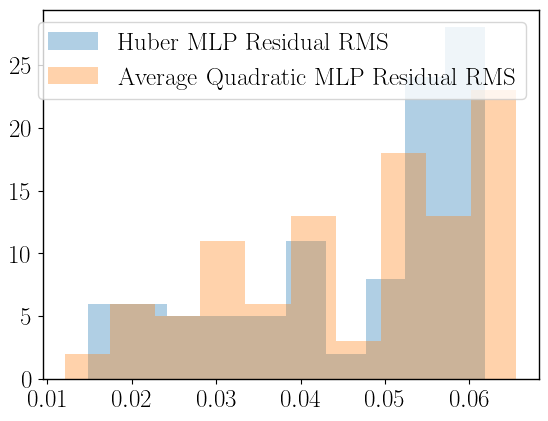

In [625]:
def RMS_np(v):
    return (np.mean(v**2, axis=0)) ** 0.5

stacked_all_residuals_Huber=np.vstack(all_residuals_Huber)

print(stacked_all_residuals_Huber.shape)
# average_residual = np.mean(stacked_all_residuals, axis=0)
# print(average_residual)
# plt.hist(average_residual, label='average residuals');
Huber_RMS = RMS_np(stacked_all_residuals_Huber)
print(Huber_RMS)
plt.hist(Huber_RMS, label = 'Huber MLP Residual RMS',alpha=0.35)

stacked_all_residuals_average_quadratic = np.vstack(all_residuals_average_quadratic)
Average_quadratic_RMS = RMS_np(stacked_all_residuals_average_quadratic)
plt.hist(Average_quadratic_RMS, label = 'Average Quadratic MLP Residual RMS',alpha=0.35)

plt.legend();plt.show()